<img src="Images/Pharmacy.png">
Ilustração por Glenn Thomas

# PROJETO DE PREVISÃO DE VENDAS - CASO ROSSMANN

Rossmann é uma rede de drogarias com operação em mais de sete países europeus. Vários fatores influenciam o faturamento das lojas, como promoções, presença de concorrentes, feriados estaduais e escolares, sazonalidade e localização. Com dados disponibilizados pela própria Rossmann na plataforma do Kaggle, o objetivo desse projeto é desenvolver um modelo de Machine Learning supervisionado que seja capaz de prever as vendas das próximas seis semanas, e criar uma API para disponibilizá-lo. 

Além do modelo de ML, durante o desenvolvimento do projeto serão utilizadas habilidades como o entendimento do negócio, levantamento e validação de hipóteses, análise descritiva, visualização, tratamento e transformação dos dados.

**Os arquivos utilizados:**

- **train.csv** - historical data including Sales;
- **test.csv** - historical data excluding Sales;
- **sample_submission.csv** - a sample submission file in the correct format;
- **store.csv** - supplemental information about the stores.

**Variáveis presentes nos arquivos:**

A maioria das variáveis possuem nomes auto-explicativos. Aquelas que não possuem:

- **Id** - an Id that represents a (Store, Date) duple within the test set;
- **Store** - a unique Id for each store;
- **Sales** - the turnover for any given day (this is what you are predicting);
- **Customers** - the number of customers on a given day;
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open;
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None;
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools;
- **StoreType** - differentiates between 4 different store models: a, b, c, d;
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended;
- **CompetitionDistance** - distance in meters to the nearest competitor store;
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened;
- **Promo** - indicates whether a store is running a promo on that day;
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating;
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2;
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# 0.0 IMPORTAÇÕES

## 0.1 Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
import random as rnd
import warnings
import pickle

from IPython.core.display         import HTML
from IPython.display              import Image
from statsmodels.stats.diagnostic import lilliefors as lillie
from boruta                       import BorutaPy
from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble             import RandomForestRegressor
from sklearn.metrics              import mean_absolute_error, mean_squared_error
from sklearn.linear_model         import LinearRegression, Lasso

warnings.filterwarnings('ignore')

## 0.2 Funções de Suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()


def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - ((k-1) * (r-1)/(n-1)))
    kcorr = k - ((k-1)**2/(n-1))
    rcorr = r - ((r-1)**2/(n-1))
    
    return np.sqrt((chi2corr/n)/(min (kcorr-1, rcorr-1)))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))



def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation (x_training, kfold, model_name, model, verbose=False):


    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        
        if verbose:

            print('\nKFold Number: {}'.format(k))

        # inicio e fim da validação

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7) # seis semanas anteriores à data máxima

        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)


        # filtrando o dataset

        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_start_date)]


        # dataset de treino e teste

        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']


        # modelo

        m = model.fit(xtraining, ytraining)

        # prediction

        yhat = m.predict(xvalidation)

        # performance

        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))    


        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])
  



Populating the interactive namespace from numpy and matplotlib


## 0.3 Carregando os dados

In [3]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
216234,1040,1,2015-01-19,6959,750,1,0,0,0,a,a,4030.0,2.0,2013.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
96245,356,3,2015-05-06,6542,452,1,1,0,0,d,c,8970.0,12.0,2007.0,1,22.0,2012.0,"Feb,May,Aug,Nov"
900768,634,1,2013-04-15,4069,492,1,0,0,0,d,a,18610.0,NaN,NaN,0,NaN,NaN,NaN
180540,1026,5,2015-02-20,11495,1332,1,1,0,0,c,a,450.0,6.0,2011.0,1,48.0,2012.0,"Mar,Jun,Sept,Dec"
166872,738,3,2015-03-04,9813,760,1,1,0,0,d,c,5980.0,10.0,2005.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Renomeando colunas

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename

df1.columns = cols_new

## 1.2 Dimensão da amostra

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Tipagem dos dados

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# competition_distance 
# quando a observação não possui dados da variável competition_distance é porque o concorrente mais próximo está muito distante
  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x) 


# competition_open_since_month
# mesmo não sabendo a data de abertura de alguns concorrentes, eles existem, e dessa forma, para preencher os NAs, utiliza-se a própria data da venda

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# competition_open_since_year
# nesta variável, os dados faltantes foram preenchidos utilizando a mesma metodologia da variável anterior

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                         

# promo2_since_week
# mesma metodologia das variáveis anteriores

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year 
# mesma metodologia das variáveis anteriores

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [13]:
# promo_interval
# verificar se no dia da venda a loja estava em promoção

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Modificação da tipagem dos dados

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)


## 1.7 Estatística descritiva

In [17]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64','datetime64[ns]'])

### 1.7.1 Variáveis numéricas

In [18]:
# tendência central

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersão e posição

d1 = pd.DataFrame(num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame(num_attributes.apply( min   )).T
d3 = pd.DataFrame(num_attributes.apply( max   )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
                  
                  
# concatenate
                  
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Variáveis categóricas

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

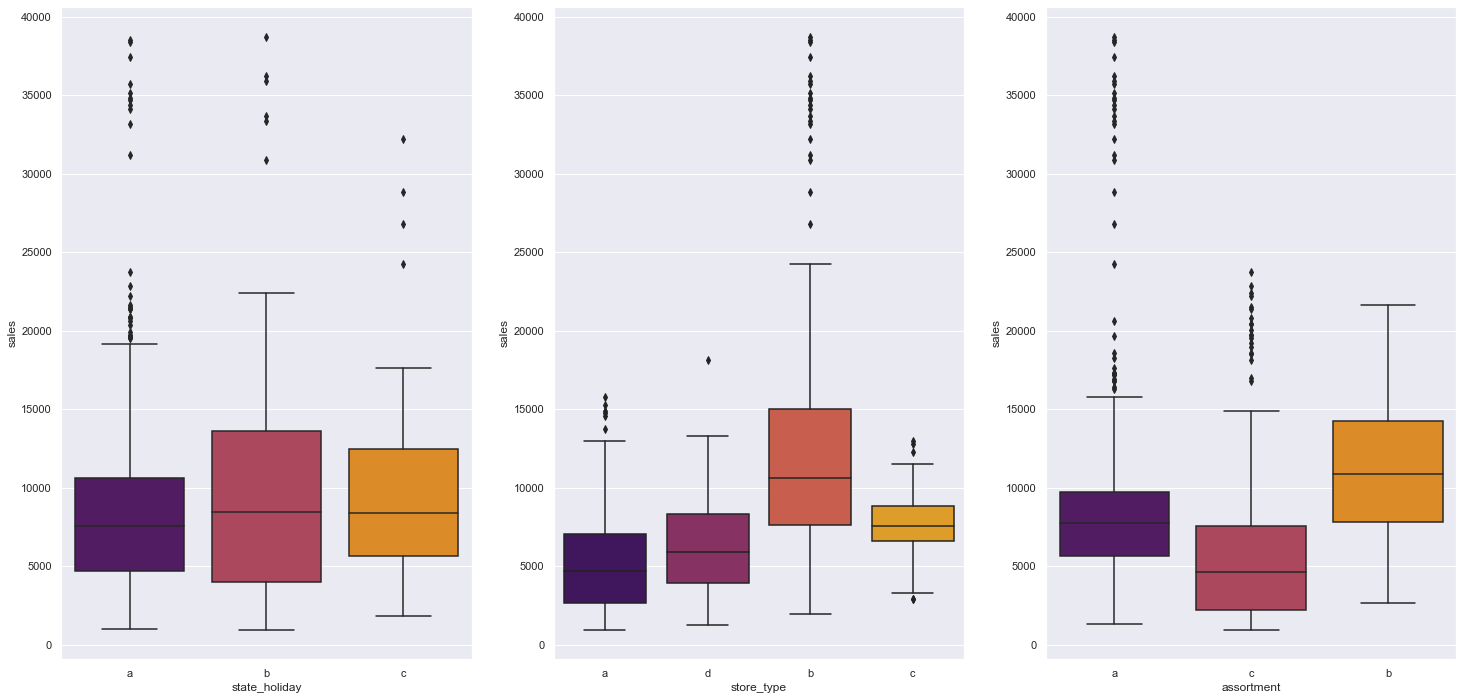

In [21]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales',data=aux1, palette='inferno')

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1, palette='inferno')

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales',data=aux1, palette='inferno')

# 2.0 FEATURING ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipóteses

.

<img src="Images/MindMap.png">

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais;

**2.** Lojas com maior estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com menor porte deveriam vender menos;

**5.** Lojas com maior sortimento deveriam vender mais;

**6.** Lojas com competidores mais próximos deveriam vender menos;

**7.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais;

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais;

**3.** Lojas que possuem preços menores deveriam vender mais;

**4.** Lojas que possuem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas deveriam vender mais;

**6.** Lojas com mais dias de promoção deveriam vender mais;

**7.** Lojas com promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas no feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos nos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Lista Final de Hipóteses

Escolhendo as hipóteses que podem ser respondidas com os dados disponíveis no momento.

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores há mais tempo deveriam vender mais;

**4.** Lojas com promoções ativas há mais tempo deveriam vender mais;

**5.** Lojas com promoções consecutivas deveriam vender mais.

**6.** Lojas abertas no feriado de Natal deveriam vender mais;

**7.** Lojas deveriam vender mais ao longo dos anos;

**8.** Lojas deveriam vender mais no segundo semestre do ano;

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**10.** Lojas deveriam vender menos nos finais de semana;

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [24]:
# year

df2['year'] = df2['date'].dt.year


# month

df2['month'] = df2['date'].dt.month


# day

df2['day'] = df2['date'].dt.day


# week of year

df2['week_of_year'] = df2['date'].dt.weekofyear


# year week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment

df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x =='a' else 'extra' if x=='b' else 'extended')


# stateholiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3.0 FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das colunas

In [27]:
cols_drop = ['customers','open', 'promo_interval','month_map']

df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

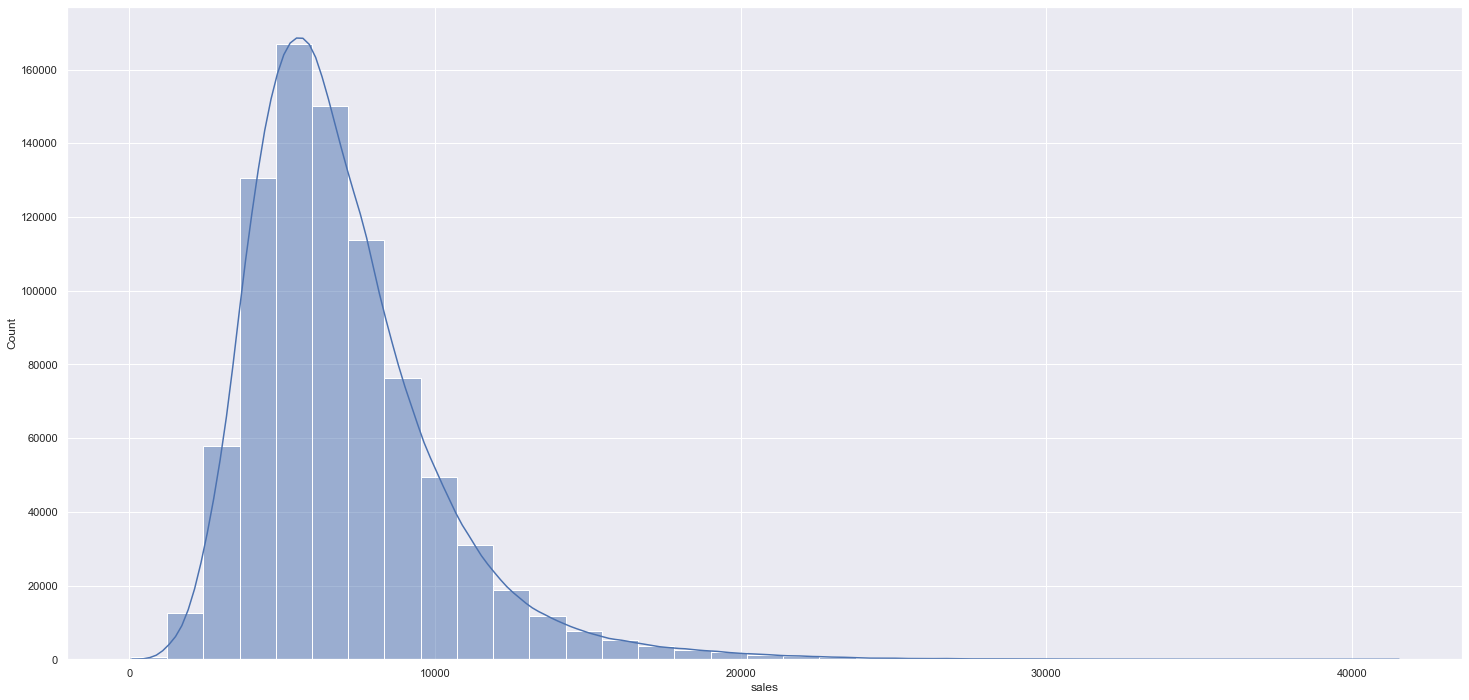

In [29]:
sns.histplot(df4['sales'], kde=True, bins=35);

#### 4.1.1.1 Teste de Normalidade

- Nível de significância de 0,05 ou 5%
- Ho = distribuição normal: p>0.05
- Ha = distribuição não normal: p<=0.05

In [30]:
lillie(df4['sales'], dist='norm')

(0.08800999429403977, 0.0009999999999998899)

Text(0.5, 1.0, 'Normal Q-Q plot')

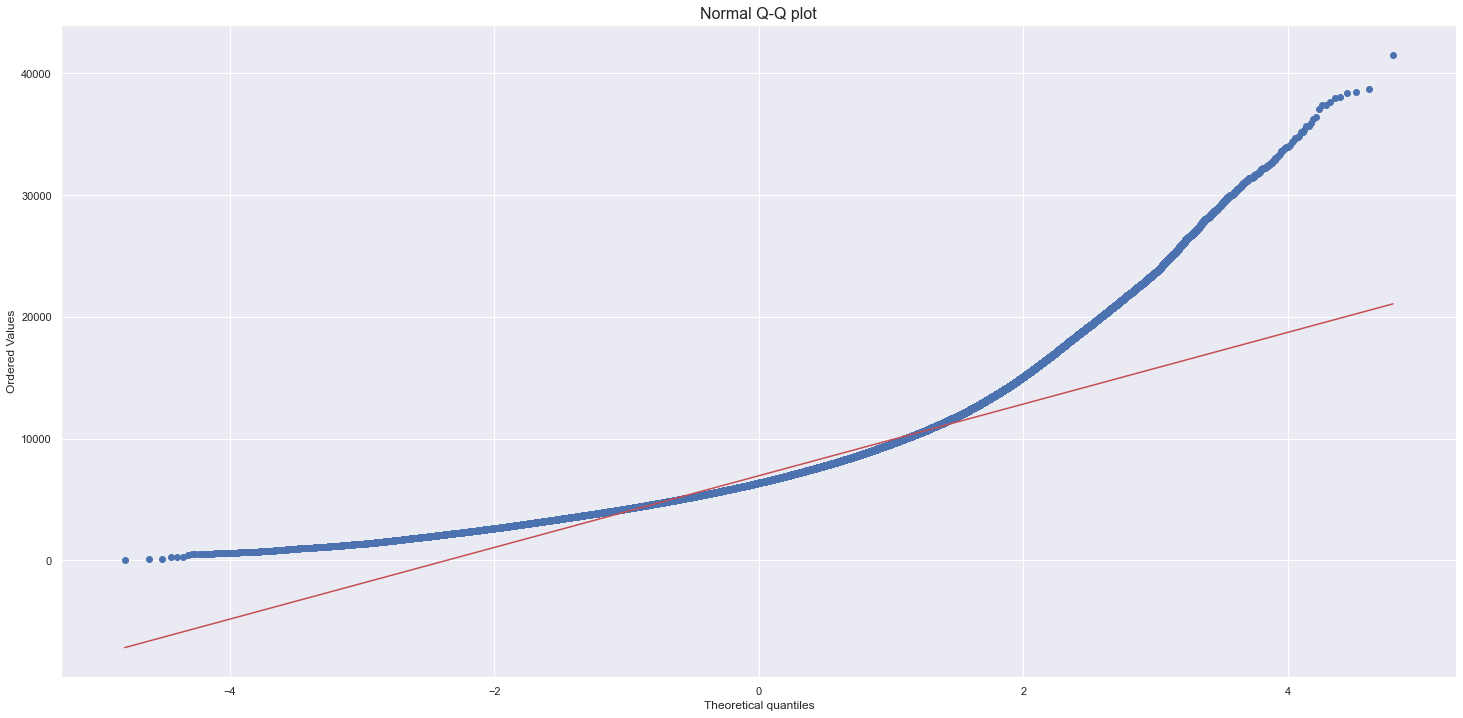

In [31]:
stats.probplot(df4['sales'], dist='norm', plot=plt)
plt.title('Normal Q-Q plot',fontsize=16)

**Conclusão:** A distribuição da variável 'sales' não é normal.

### 4.1.2 Variáveis Numéricas

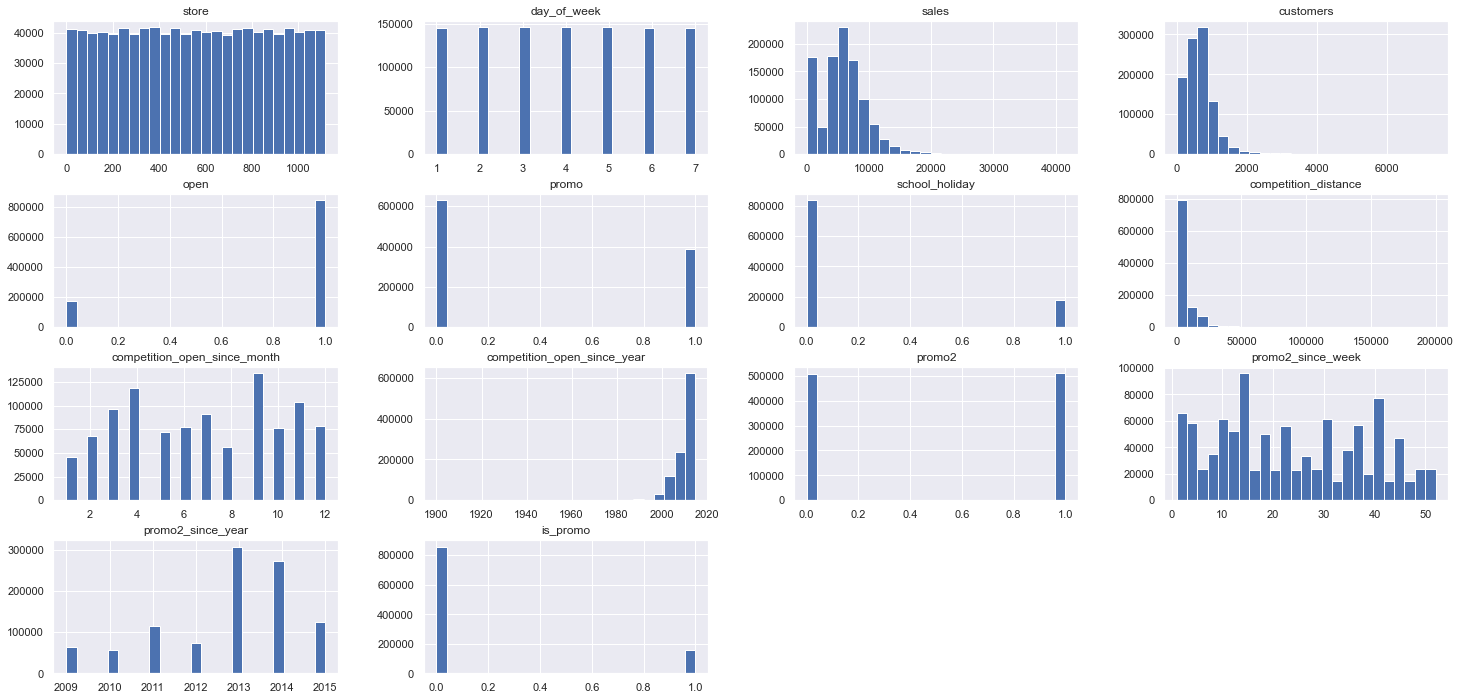

In [32]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis Categóricas

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

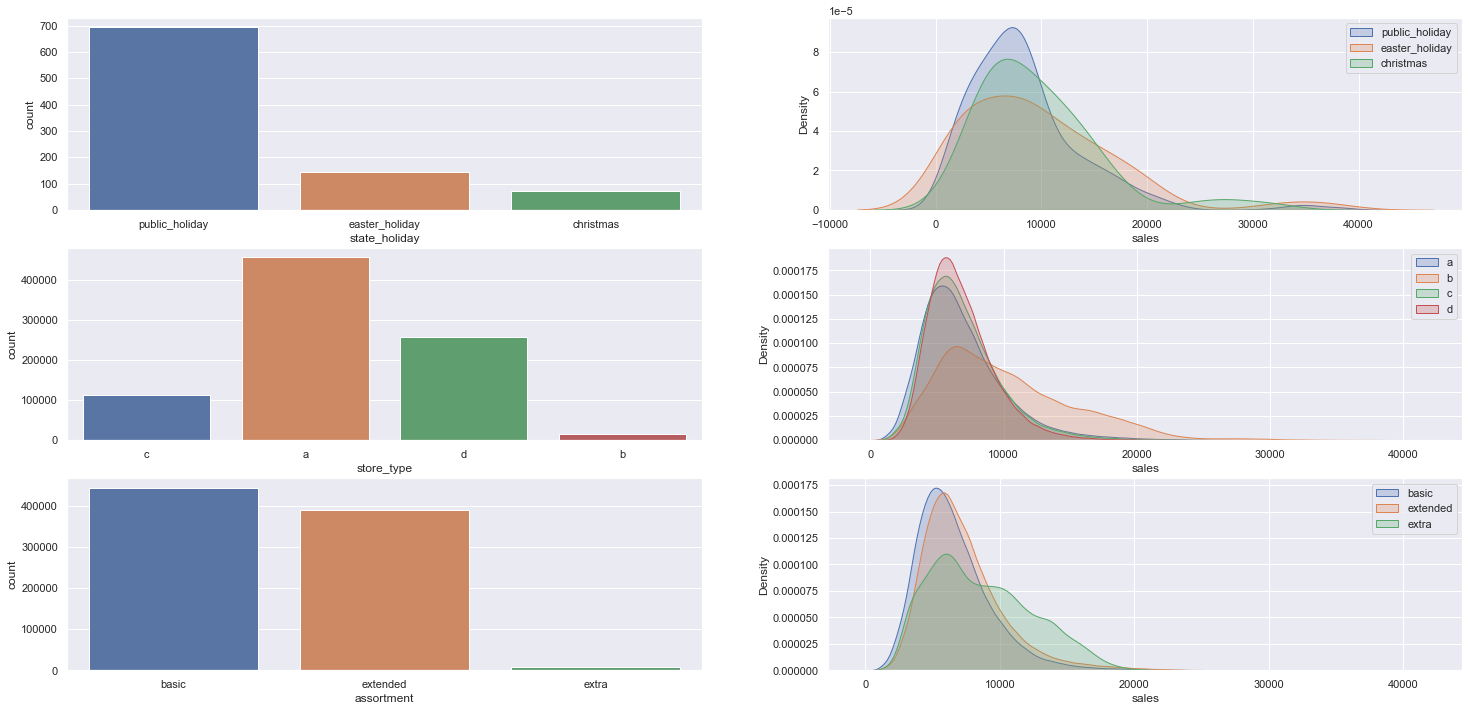

In [34]:
# state_holiday

a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', shade=True)

plt.legend()

# ---------------------------------------------------------------------
# store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)

plt.legend()

# ---------------------------------------------------------------------
# assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)


plt.legend()


## 4.2 Análise Bivariada

### 4.2.1 H1: Lojas com maior sortimento deveriam vender mais
**Hipótese aceita**, lojas com maior sortimento vendem, em média, mais do que as outras

<AxesSubplot:xlabel='year_week'>

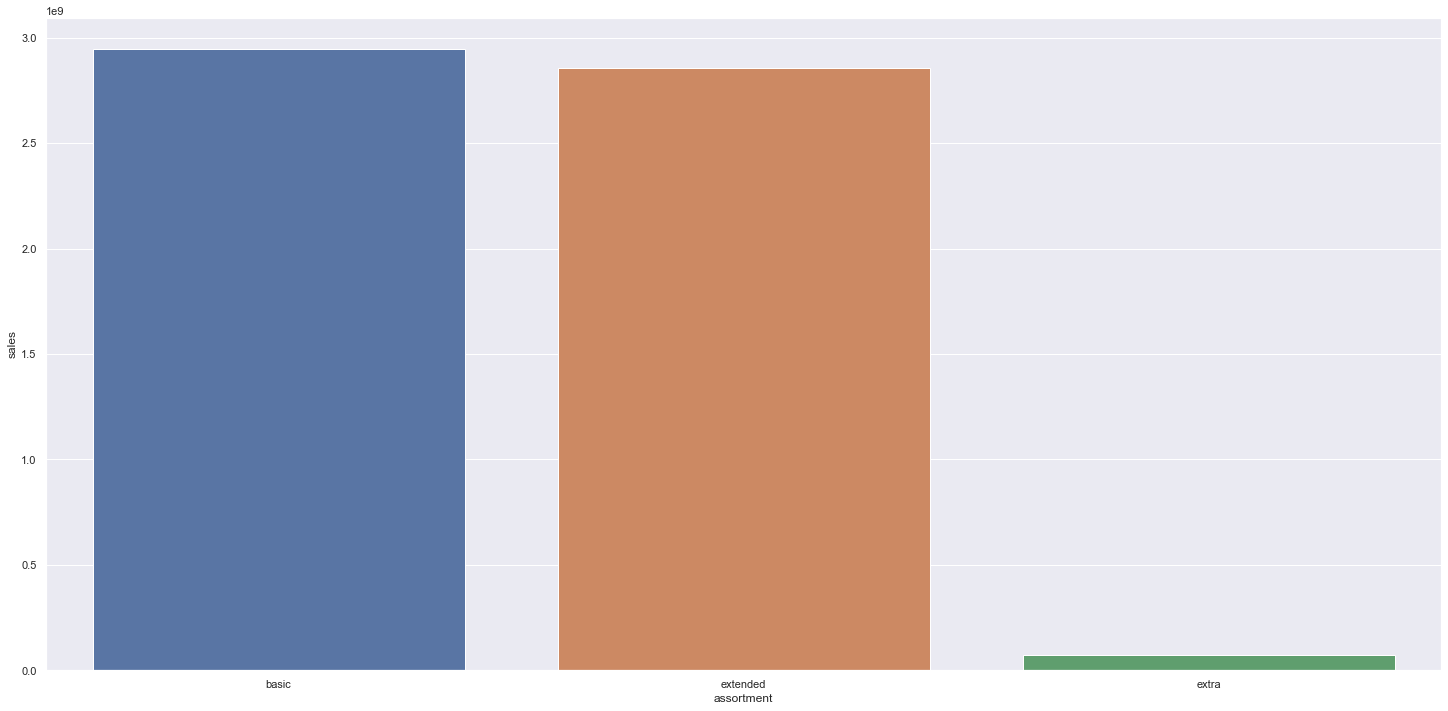

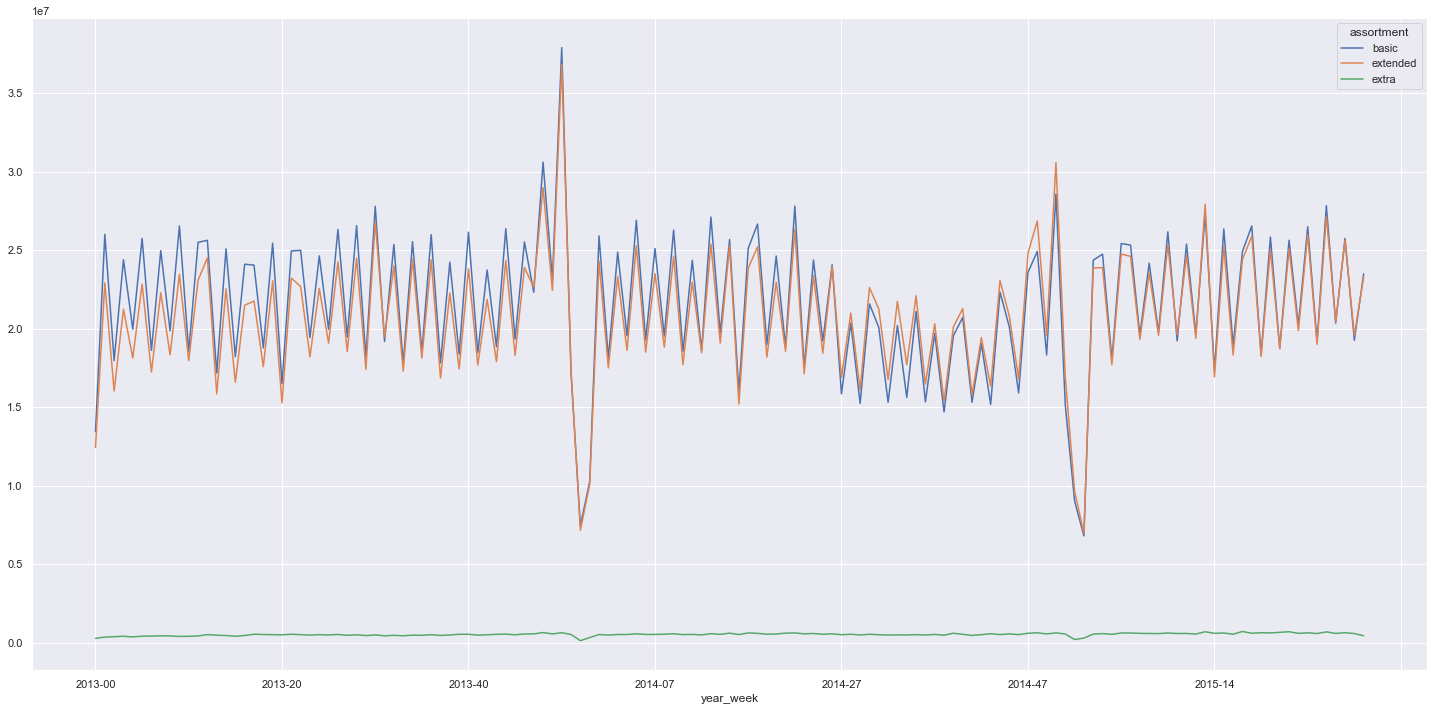

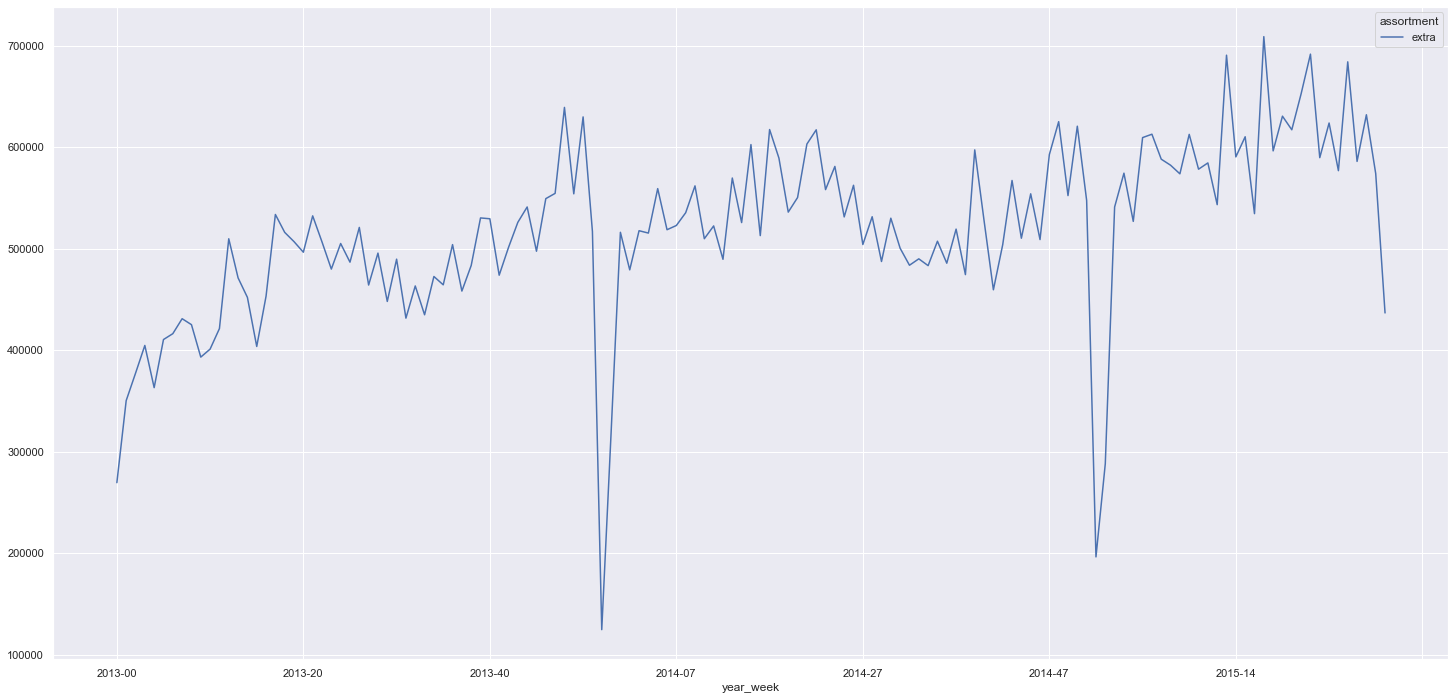

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

Utilizando apenas a soma dos valores absolutos de vendas, os números de 'basic' e 'extended' são tão superiores a 'extra' que no gráfico de linhas, essa última até parece ter uma venda linear, por causa da escala. No entanto, é interessante verificar a média de venda, uma vez que as existe uma quantidade diferente de lojas de acordo com seu sortimento.

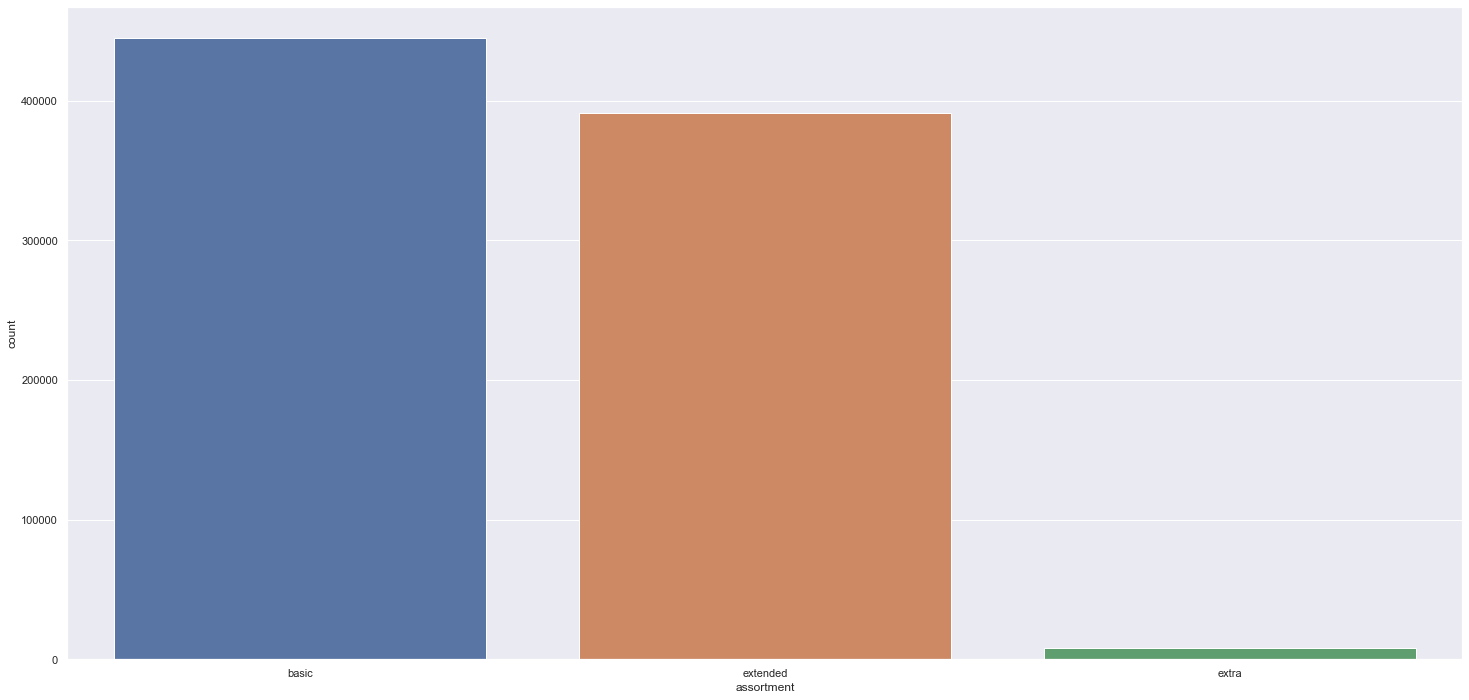

In [36]:
sns.countplot(df4['assortment']);

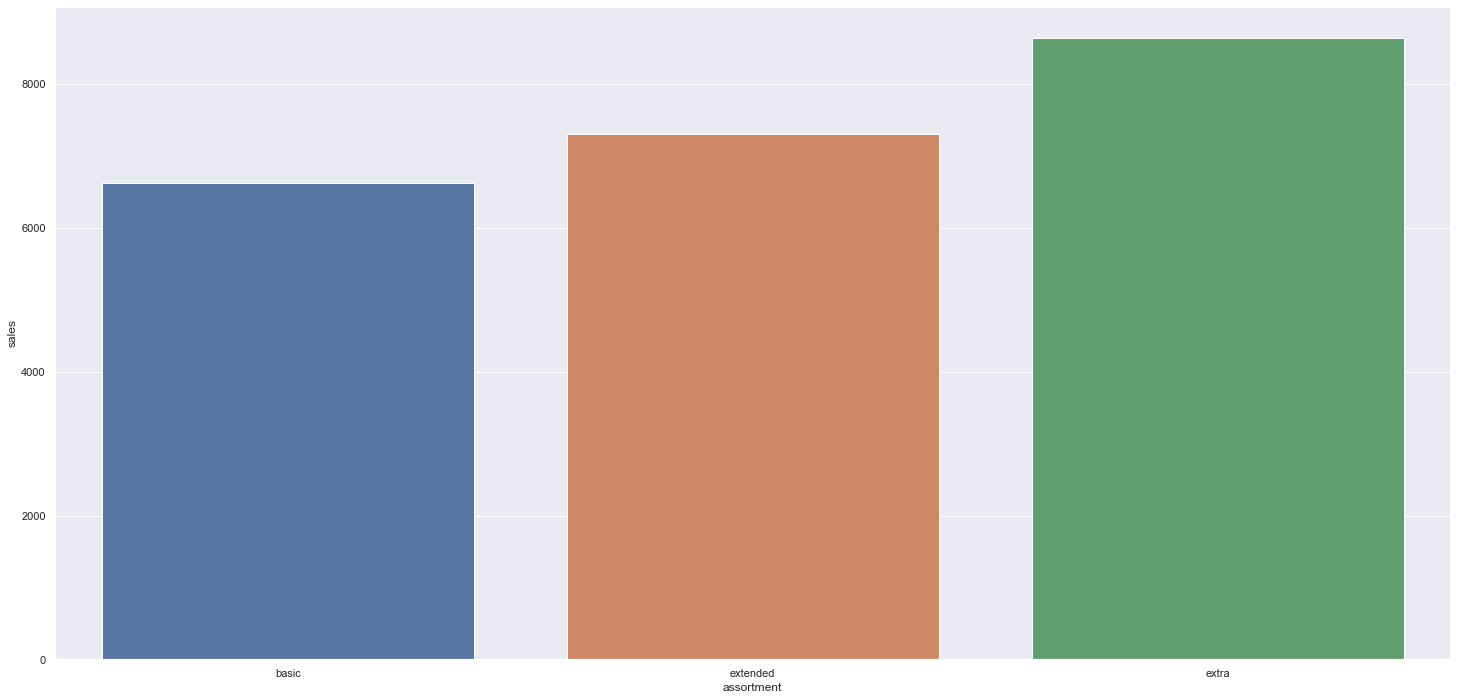

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

sns.barplot(x='assortment', y='sales', data=aux1);

**Conclusão:** Verificando as vendas médias, de fato o sortimento faz diferença e as lojas 'extra' possuem números superiores. Portanto, hipótese aceita.

### 4.2.2 H2: Lojas com competidores mais próximos deveriam vender menos
**Hipótese rejeitada**, lojas com competidores mais próximos não vendem, em média, mais do que lojas que possuem competidores mais distantes

<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

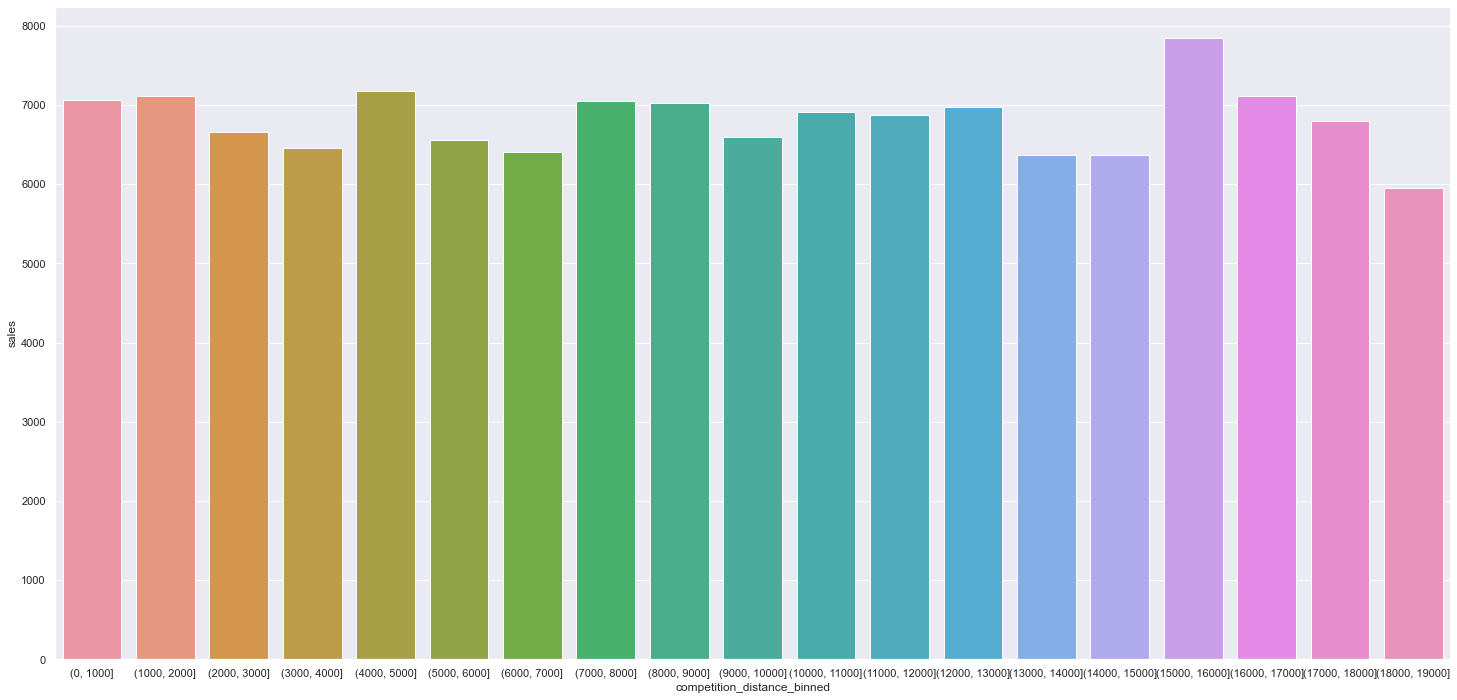

In [38]:
aux1=df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

bins=list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2=aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

<AxesSubplot:>

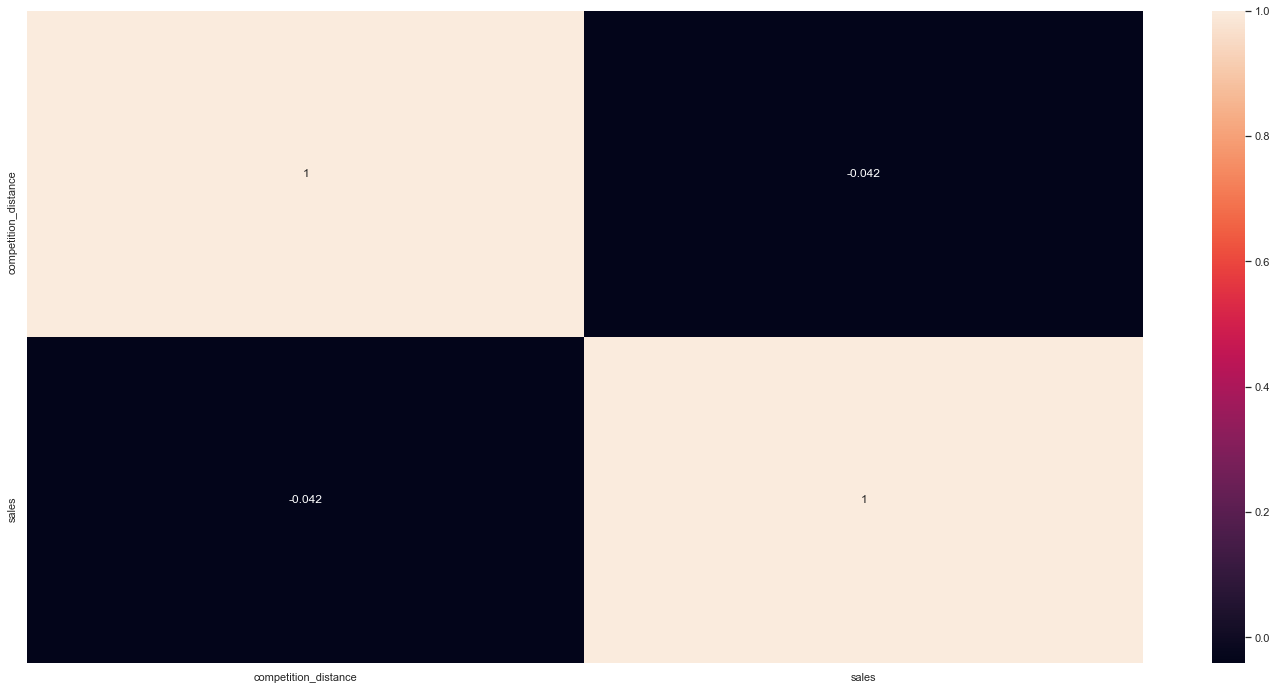

In [39]:
sns.heatmap(df4[['competition_distance','sales']].corr(), annot=True)

### 4.2.3 H3: Lojas com competidores há mais tempo deveriam vender mais
**Hipótese rejeitada**, praticamente não existe correlação entre o tempo do competidor aberto e o número de vendas da loja

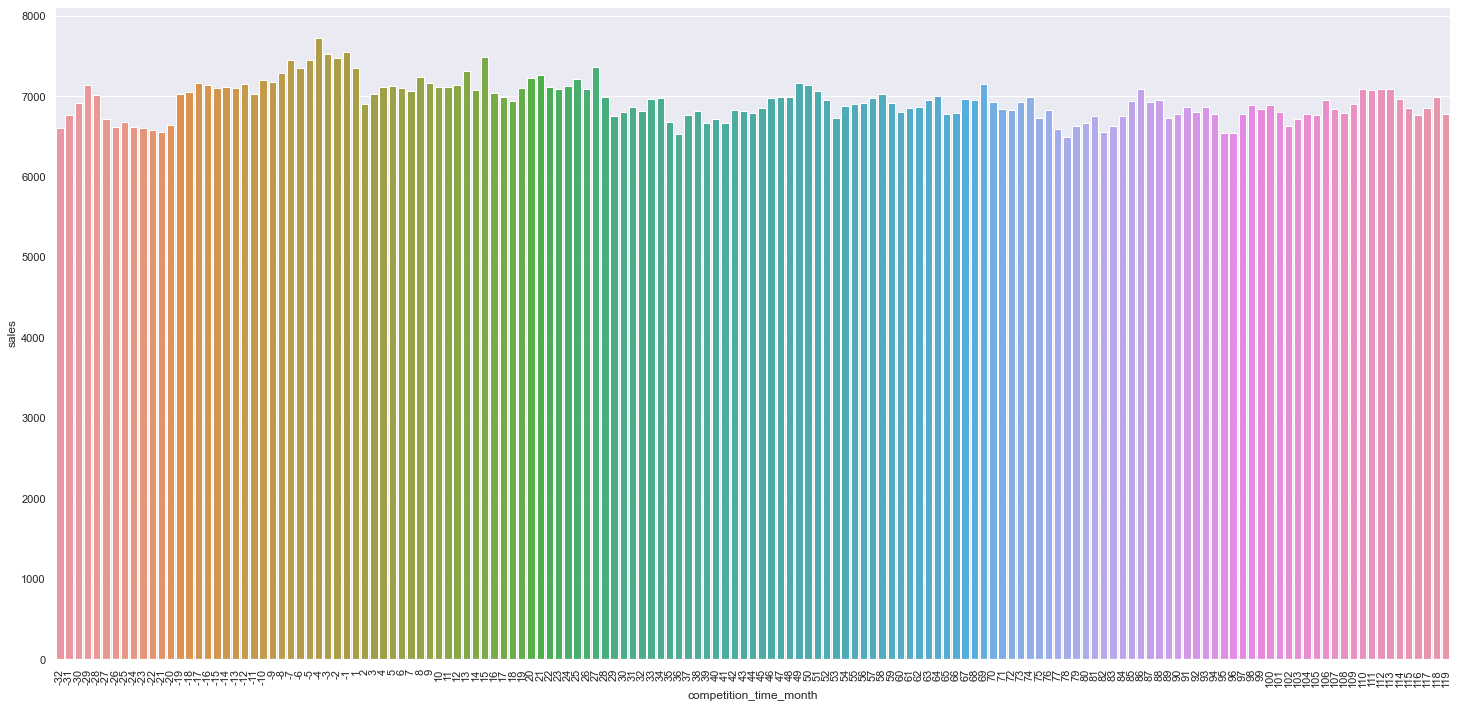

In [40]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]

sns.barplot(x='competition_time_month', y='sales', data=aux2)

plt.xticks(rotation=90);

<AxesSubplot:>

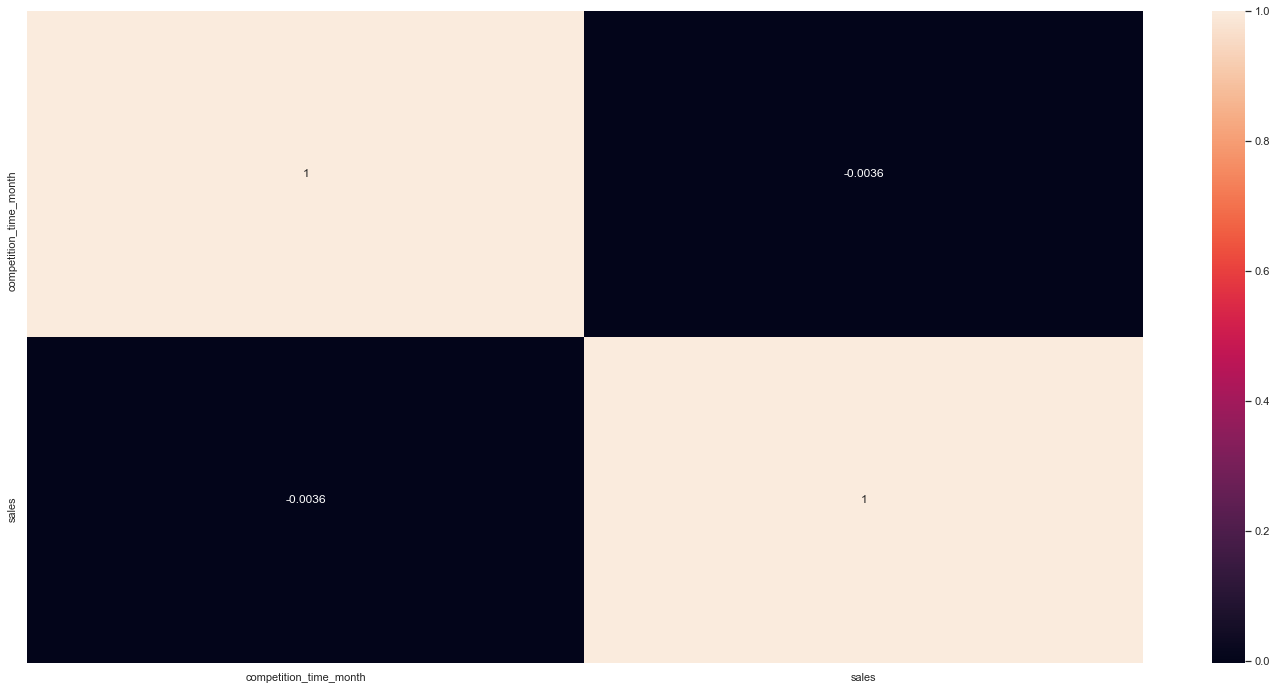

In [41]:
sns.heatmap(df4[['competition_time_month','sales']].corr(), annot=True)

### 4.2.4 H4: Lojas com promoções ativas há mais tempo deveriam vender mais
**Hipótese rejeitada**, após certo período a promoção perde força e as vendas caem 

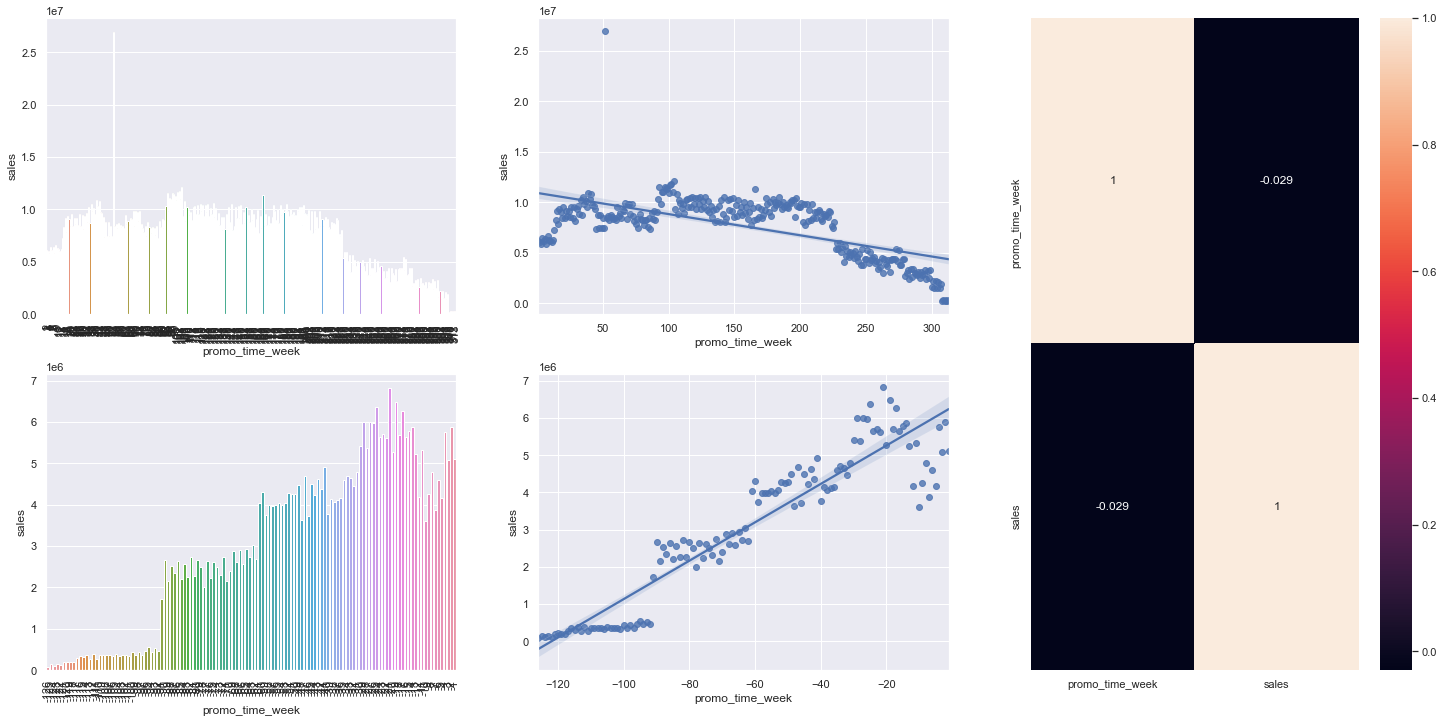

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] >0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.5 H5: Lojas com mais promoções consecutivas deveriam vender mais
**Hipótese rejeitada**, após certo período a promoção perde força e as vendas caem 

In [43]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


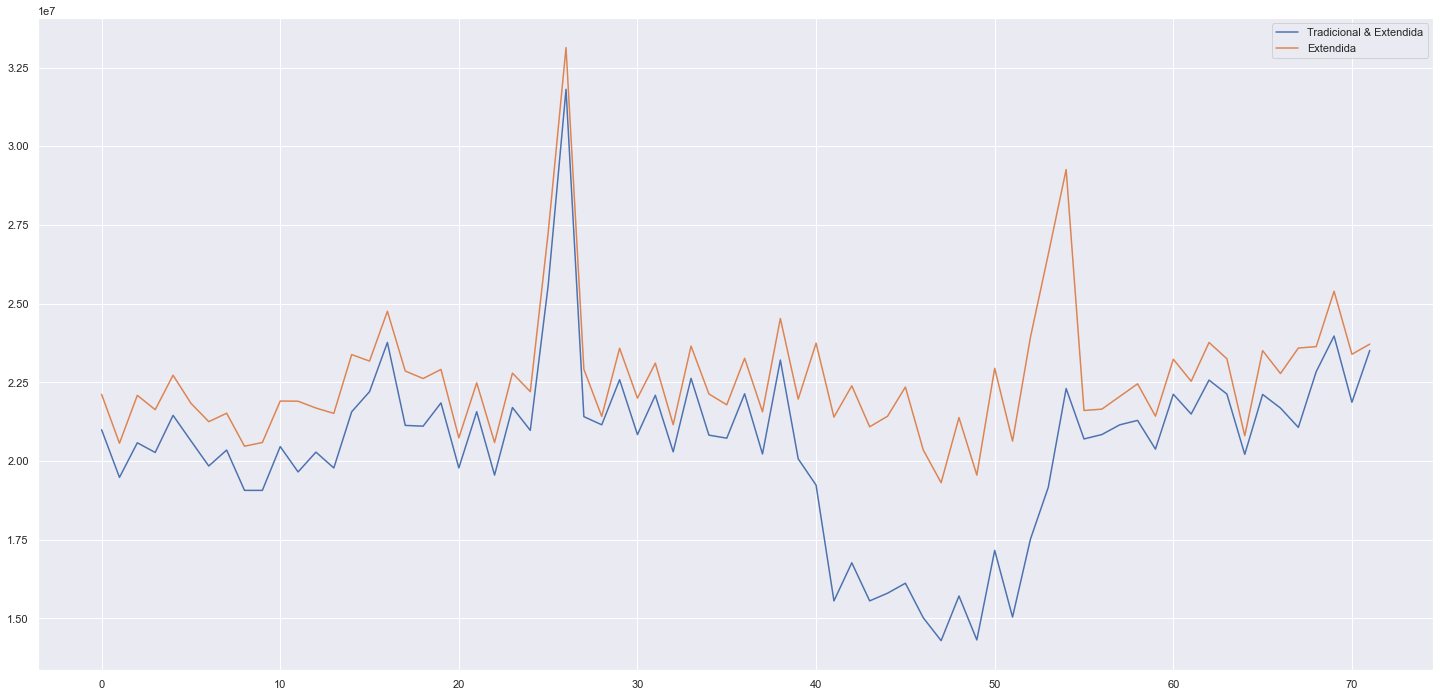

In [44]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()

aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### 4.2.6 H6: Lojas abertas no feriado de Natal deveriam vender mais
**Hipótese partialmente aceita**, pois as lojas vendem mais no Natal do que nos dias normais e nos feriados públicos, mas vendem menos que na páscoa

<AxesSubplot:xlabel='year', ylabel='sales'>

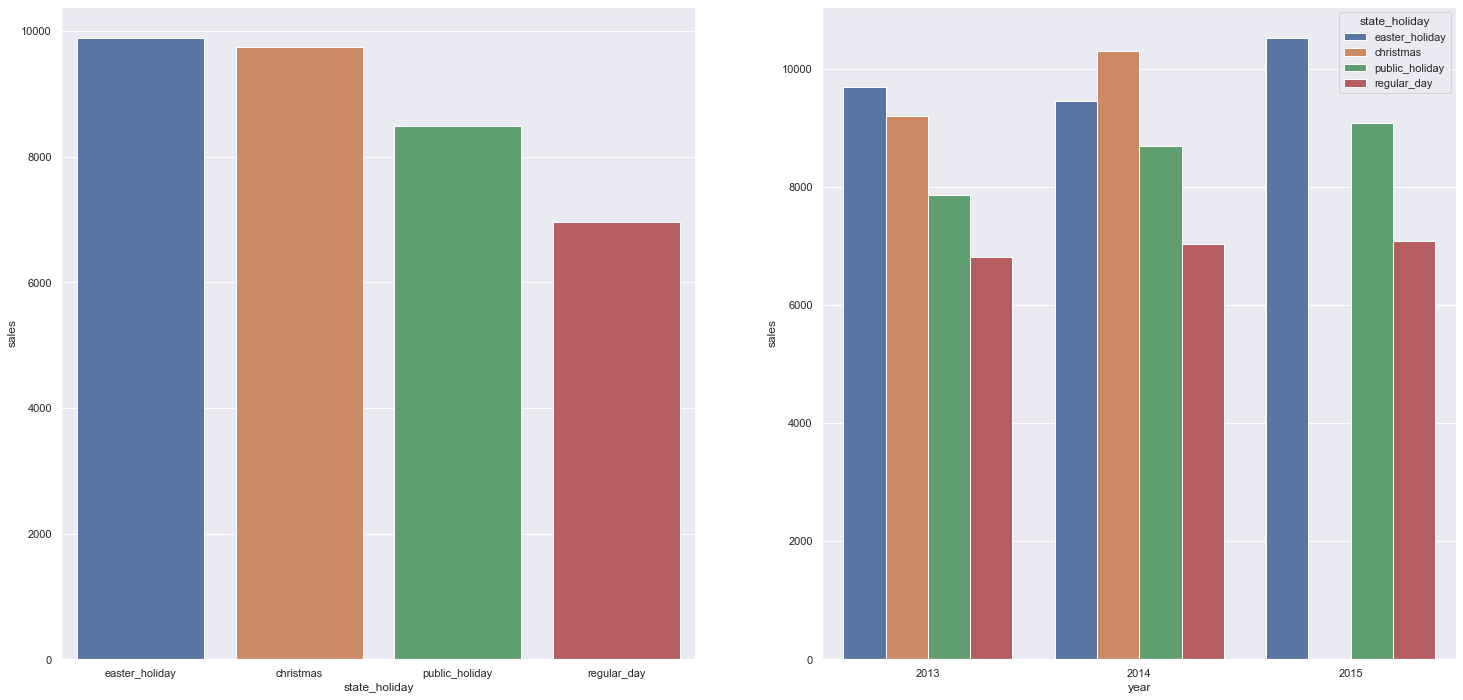

In [45]:
plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index().sort_values('sales', ascending=False)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index().sort_values('sales', ascending=False)
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2)

### 4.2.7 H7: Lojas deveriam vender mais ao longo dos anos
**Hipótese aceita**, a venda média das lojas vem aumentando ao longo dos anos

<AxesSubplot:>

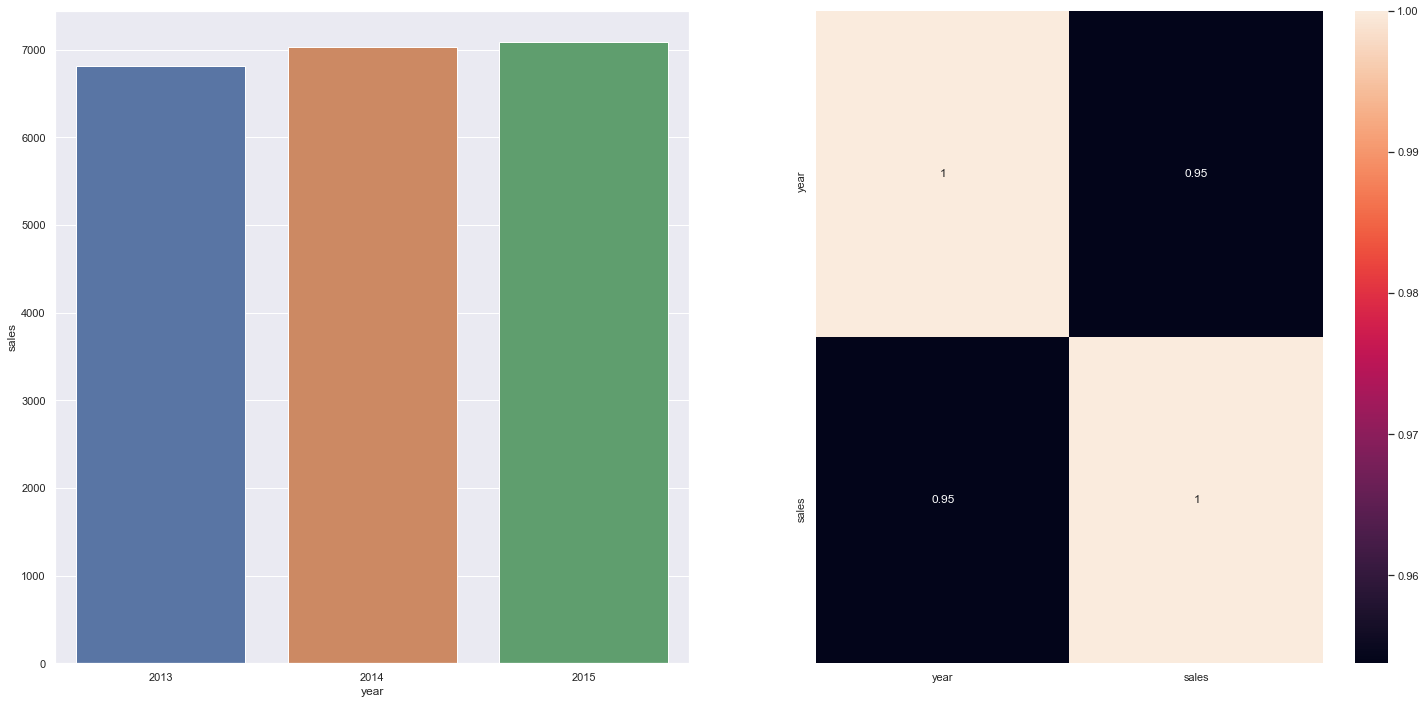

In [46]:
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index().sort_values('sales', ascending=False)

plt.subplot(1,2,1)
sns.barplot(x='year',y='sales', data=aux1)

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### 4.2.8 H8: Lojas deveriam vender mais no segundo semestre do ano
**Hipótese aceita**, existe uma correlação moderada entre as vendas e o passar dos meses, tendo seu pico em dezembro

<AxesSubplot:>

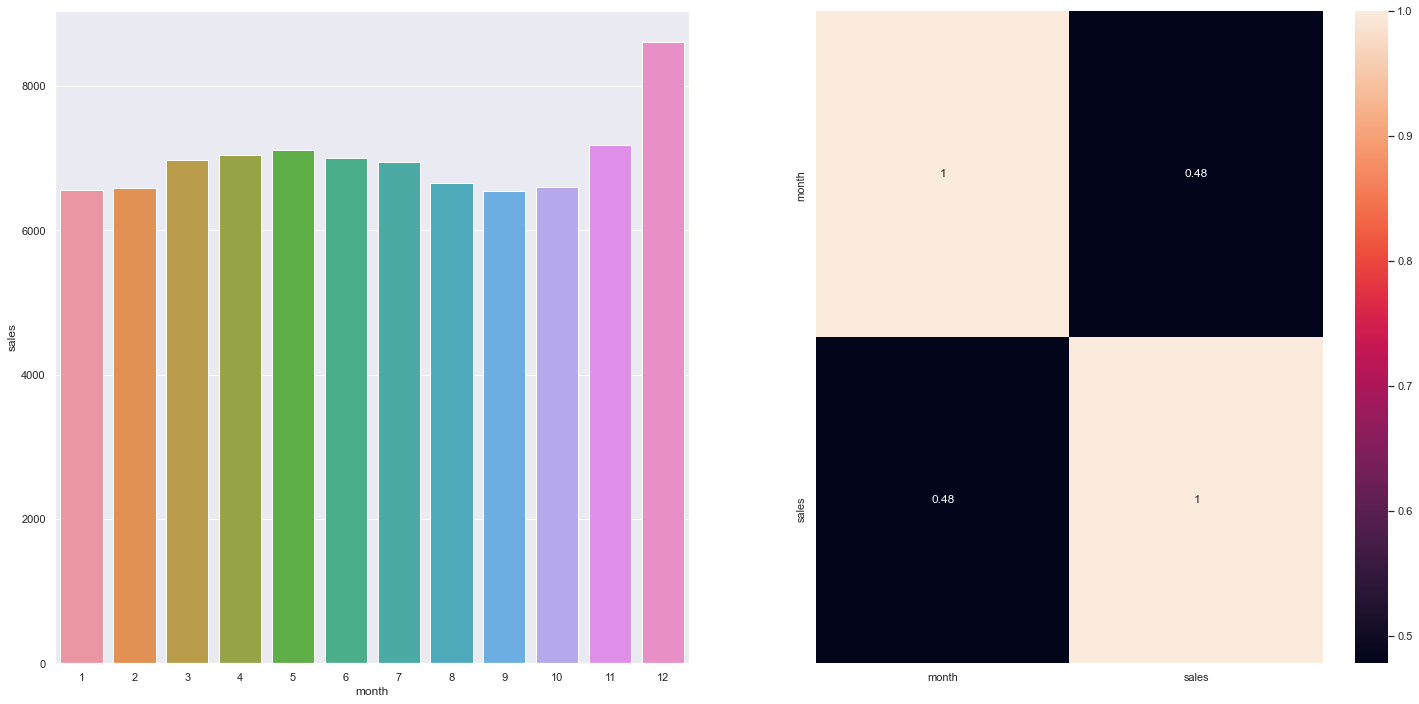

In [47]:
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index().sort_values('month')

plt.subplot(1,2,1)
sns.barplot(x='month',y='sales', data=aux1)

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### 4.2.9 H9: Lojas deveriam vender mais depois do dia 10 de cada mês
**Hipótese rejeitada**, existe uma correlação negativa fraca/moderada, então quando mais os dias aumentam, as vendas tendem a diminuir

<AxesSubplot:>

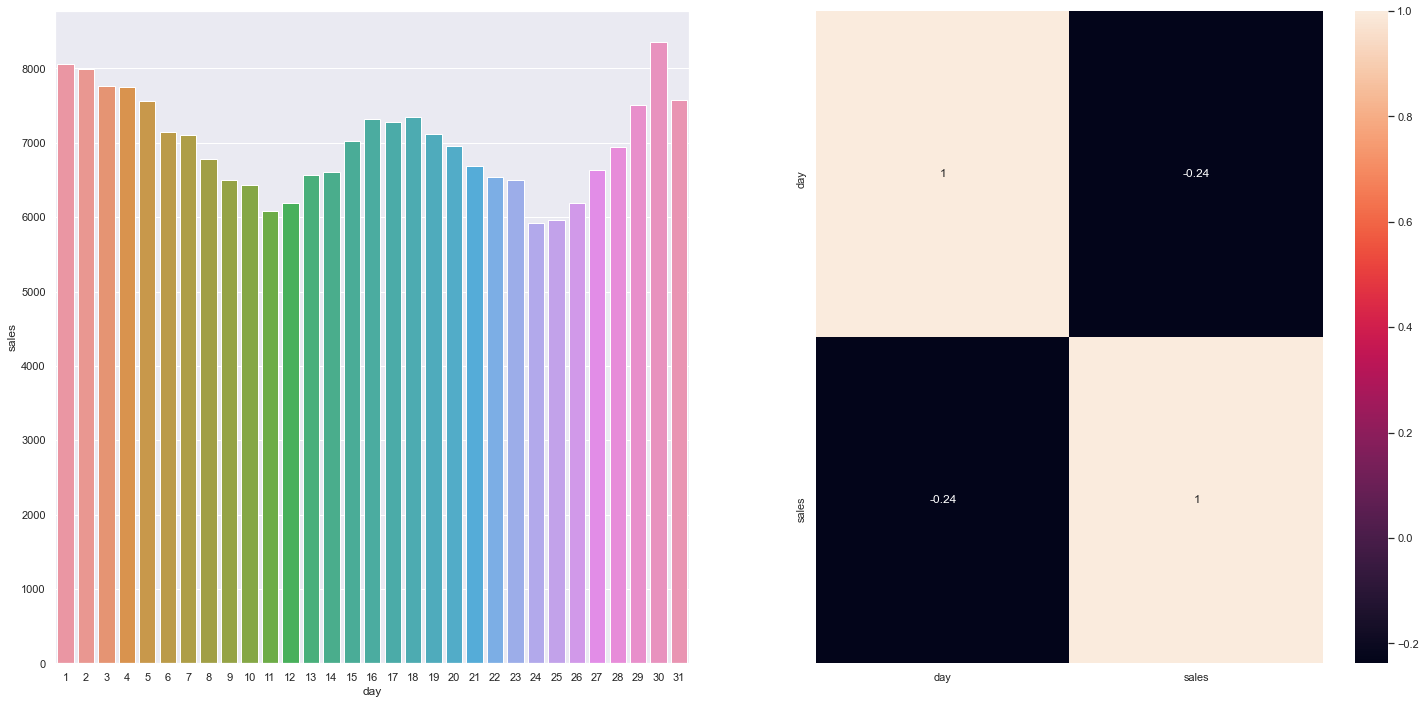

In [48]:
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index().sort_values('day')

plt.subplot(1,2,1)
sns.barplot(x='day',y='sales', data=aux1)

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### 4.2.10 H10: Lojas deveriam vender menos nos finais de semana
**Hipótese aceita**, existe uma correlação negativa fraca entre as vendas médias e os dias de semana

<AxesSubplot:>

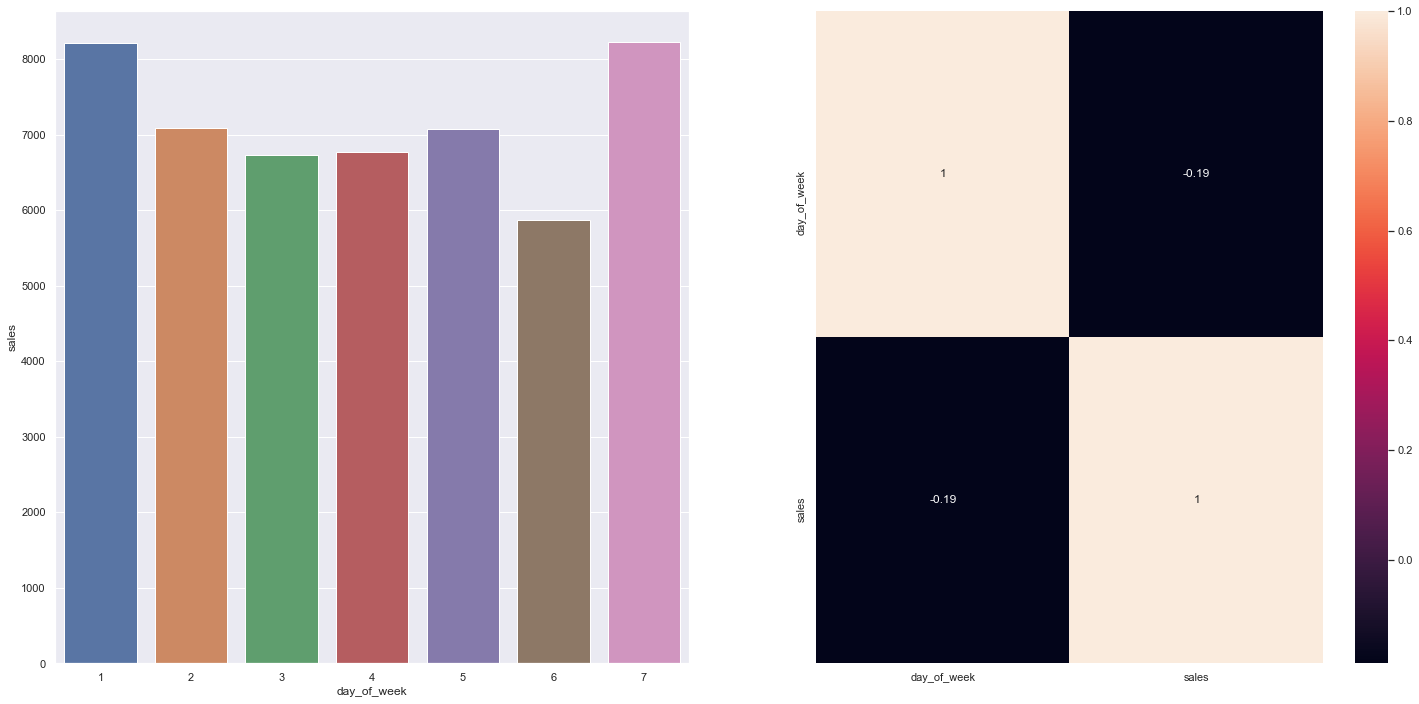

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index().sort_values('day_of_week')

plt.subplot(1,2,1)
sns.barplot(x='day_of_week',y='sales', data=aux1)

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### 4.2.11 H11: Lojas deveriam vender menos durante os feriados escolares
**Hipótese rejeitada**, o faturamento médio é maior nos feriados escolares

<AxesSubplot:xlabel='school_holiday', ylabel='sales'>

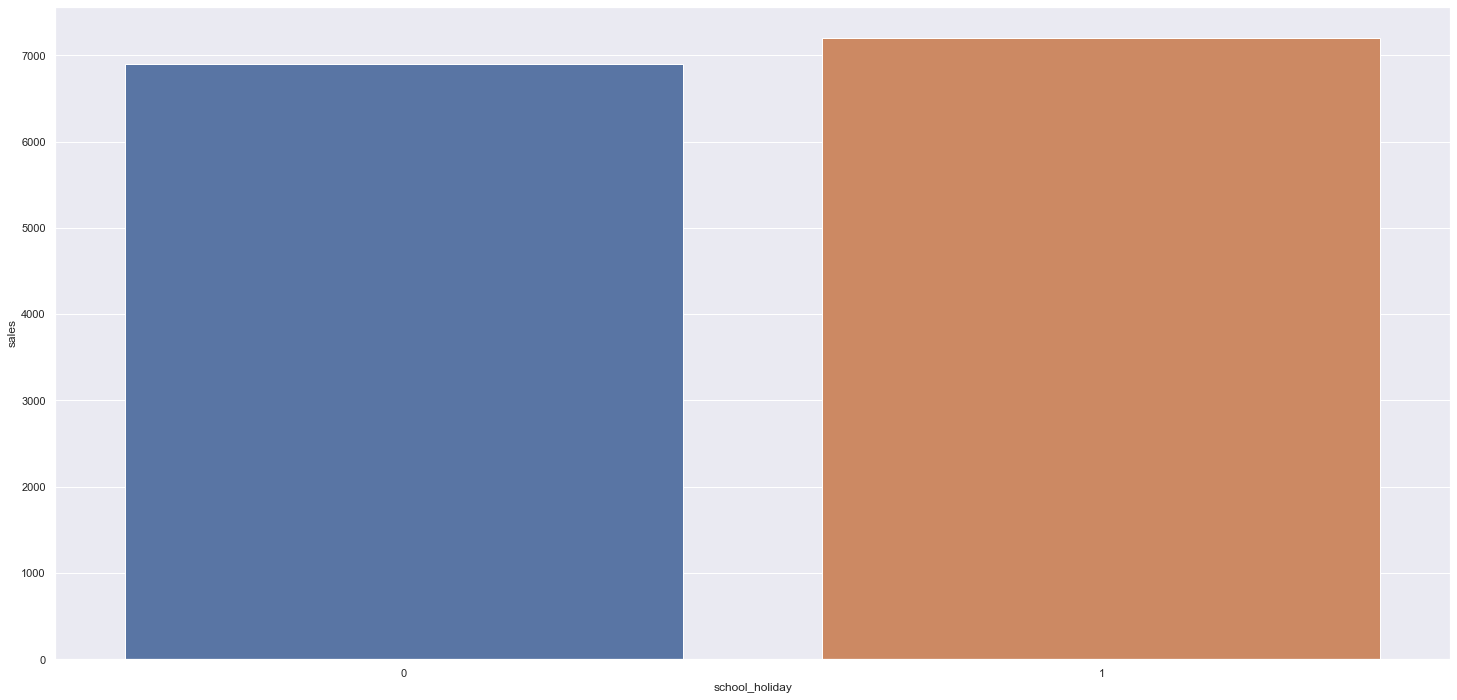

In [50]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index().sort_values('school_holiday')


sns.barplot(x='school_holiday',y='sales', data=aux1)


## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

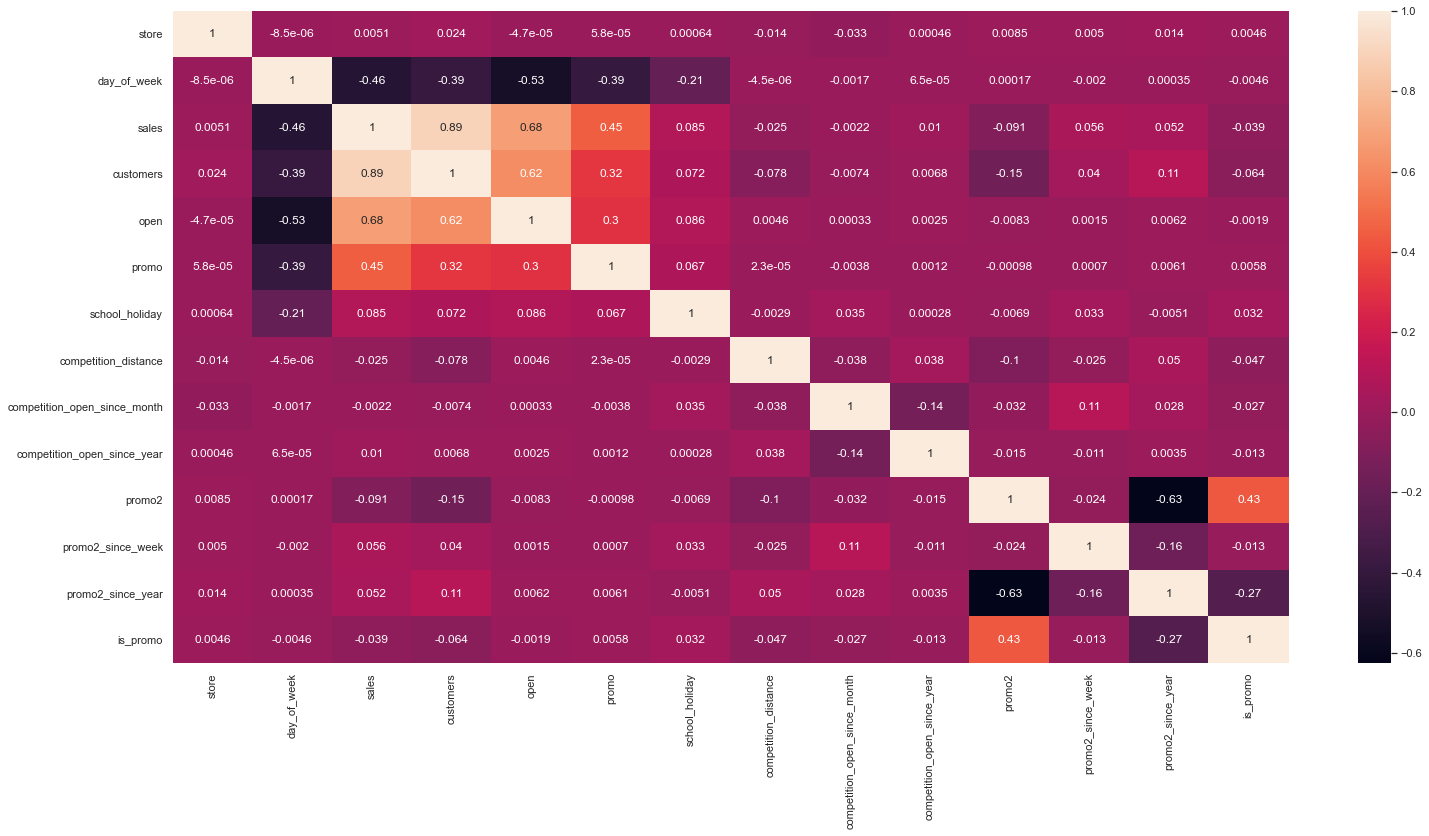

In [51]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [52]:
correlation['sales'].sort_values(ascending=False)

sales                           1.000000
customers                       0.894711
open                            0.678472
promo                           0.452345
school_holiday                  0.085124
promo2_since_week               0.055889
promo2_since_year               0.052108
competition_open_since_year     0.010006
store                           0.005126
competition_open_since_month   -0.002198
competition_distance           -0.024747
is_promo                       -0.038781
promo2                         -0.091040
day_of_week                    -0.462125
Name: sales, dtype: float64

### 4.3.2 Atributos Categóricos

In [53]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)

<AxesSubplot:>

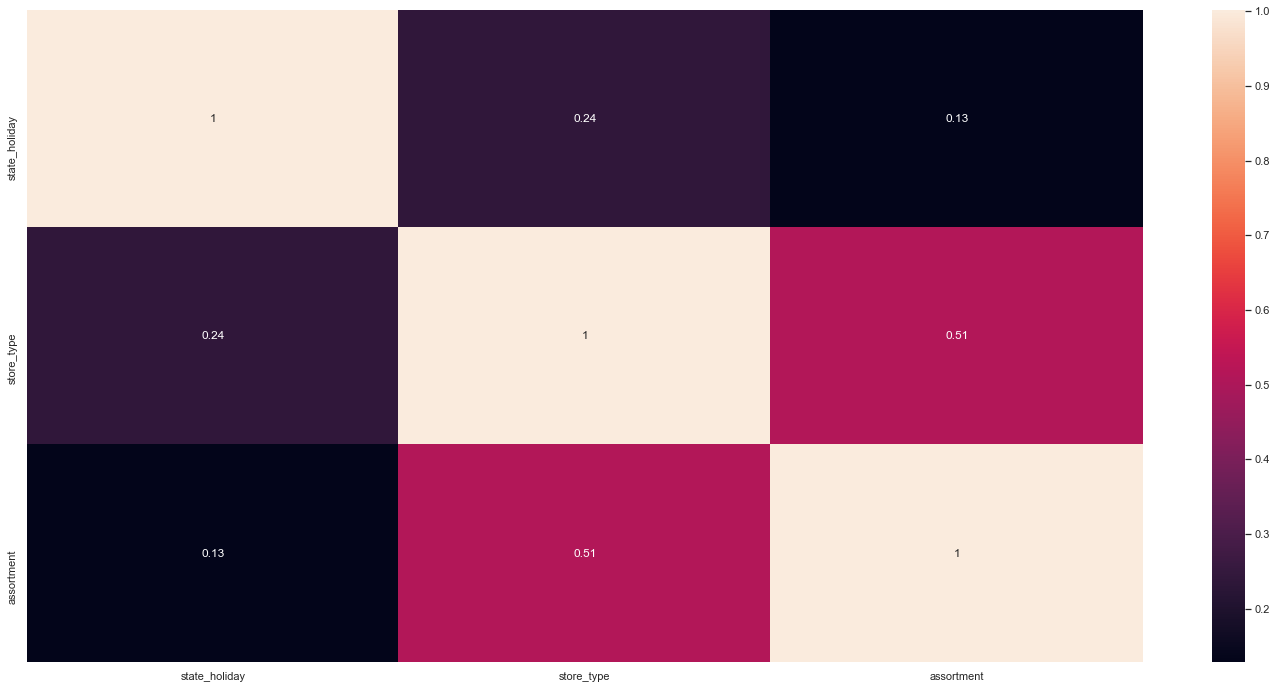

In [54]:
sns.heatmap(d, annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [55]:
df5 = df4.copy()

In [56]:
df5['competition_time_month'] = np.int64(df5['competition_time_month'])
df5['promo_time_week'] = np.int64(df5['promo_time_week'])

## 5.1 Rescaling

In [57]:
# selecionando as variáveis numéricas

a = df5.select_dtypes(include=['int64', 'float64'])

In [58]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

pickle.dump(rs, open('/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

pickle.dump(mms, open('/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/promo_time_week_scaler.pkl', 'wb'))

# year

df5['year'] = mms.fit_transform(df5[['year']].values)

pickle.dump(mms, open('/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/year_scaler.pkl', 'wb'))

## 5.2 Transformação

### 5.2.1 Encoding

In [59]:
# state_holiday - one hot encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - label encoding

le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

pickle.dump(le, open('/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/store_type_encoding.pkl', 'wb'))

# assortment - ordinal encoding

assortment_dict = {'basic':1,
                   'extended':2,
                   'extra':3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.2.2 Transformação da Variável Resposta

In [60]:
df5['sales'] = np.log1p(df5['sales'])

### 5.2.3 Variáveis de Natureza Cíclica

In [61]:
# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day of week

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# 6.0 SELEÇÃO DE FEATURES

In [62]:
df6 = df5.copy()

In [63]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 = df6.drop(cols_drop, axis=1)

## 6.1 Divisão do dataframe em Train e Test

In [64]:
# separando as últimas seis semanas como dados de teste

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) 

Timestamp('2015-06-19 00:00:00')

In [65]:
# treino

X_train = df6[df6['date']<'2015-06-19']
y_train = X_train['sales']


# teste

X_test = df6[df6['date']>='2015-06-19']
y_test = X_test['sales']


print( 'Training Min Date: {}'.format(X_train['date'].min()))
print( 'Training Max Date: {}'.format(X_train['date'].max()))

print( '\nTest Min Date: {}'.format(X_test['date'].min()))
print( 'Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Seleção de Features com Boruta

In [66]:
# train e test

#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# definindo random forest regressor


#rf = RandomForestRegressor(n_jobs=-1)


#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [67]:
#cols_selected = boruta.support_.tolist()

# features mais relevantes para o modelo

#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# features menos relevantes para o modelo

#cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta )

In [68]:
#cols_selected_boruta

In [69]:
#cols_not_selected_boruta

## 6.3 Seleção Manual das Features

In [70]:
# salvando manualmente para que não seja preciso executar o boruta todas as vezes

cols_selected_boruta = [
                 'store',
                 'promo',
                 'store_type',
                 'assortment',
                 'competition_distance',
                 'competition_open_since_month',
                 'competition_open_since_year',
                 'promo2',
                 'promo2_since_week',
                 'promo2_since_year',
                 'competition_time_month',
                 'promo_time_week',
                 'month_sin',
                 'month_cos',
                 'day_sin',
                 'day_cos',
                 'week_of_year_sin',
                 'week_of_year_cos',
                 'day_of_week_sin',
                 'day_of_week_cos']

# colunas a adicionar

feat_to_add = ['date', 'sales']

# features finais

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [71]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 MACHINE LEARNING

In [72]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1 Modelo de Média

In [73]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

# predição

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})

aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# performance

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Modelo de Regressão Linear

In [74]:
# model

lr = LinearRegression().fit(x_train, y_train)

# predição

yhat_lr = lr.predict(x_test)

# performance

lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### 7.2.1 Cross Validation: Regressão Linear

In [75]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1818.18 +/- 516.04,0.28 +/- 0.05,2665.11 +/- 881.98


## 7.3 Modelo de Regressão Linear Regularizado / Lasso

In [76]:
# model

lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# predição

yhat_lrr = lrr.predict(x_test)

# performance

lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.398668,0.289252,2743.459416


### 7.3.1 Cross Validation: Lasso

In [77]:
lasso_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1841.95 +/- 572.46,0.28 +/- 0.04,2702.85 +/- 956.43


## 7.4 Random Forest Regressor

In [78]:
# model

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# predição

yhat_rf = rf.predict(x_test)

# performance

rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.439461,0.099791,1010.188614


### 7.4.1 Cross Validation: Random Forest Regressor

In [79]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,577.7 +/- 255.45,0.11 +/- 0.05,800.21 +/- 305.53


## 7.5 XGBoost Regressor

In [80]:
# model

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=200,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# predição

yhat_xgb = model_xgb.predict(x_test)

# performance

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,4843.369066,0.659167,5553.36498


### 7.5.1 Cross Validation: XGBoost Regressor

In [81]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,4398.72 +/- 615.91,0.65 +/- 0.02,5038.85 +/- 841.1


## 7.6 Comparando a Performance dos Modelos

### 7.6.1 Performance Única

In [82]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.439461,0.099791,1010.188614
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1861.127229,0.291652,2662.291292
0,Linear Regression - Lasso,1891.398668,0.289252,2743.459416
0,XGBoost Regressor,4843.369066,0.659167,5553.364980


### 7.6.2 Perfomance Real com Cross Validation

In [83]:
modelling_result_cv = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])

modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1818.18 +/- 516.04,0.28 +/- 0.05,2665.11 +/- 881.98
0,Lasso,1841.95 +/- 572.46,0.28 +/- 0.04,2702.85 +/- 956.43
0,Random Forest Regressor,577.7 +/- 255.45,0.11 +/- 0.05,800.21 +/- 305.53
0,XGBoost Regressor,4398.72 +/- 615.91,0.65 +/- 0.02,5038.85 +/- 841.1


O modelo de XGBoost Regressor apresentou a pior performance, devido às mudanças realizadas na sua biblioteca de origem. Por ser um algoritmo interessante, decidiu-se utilizar o método de 'Hyperparameters for Fine Tunning' a fim de se encontrar os melhores parâmetros para serem aplicados no modelo e, com isso, melhorar sua performance.

# 8.0 HYPERPARAMETERS FOR FINE TUNNING

## 8.1 Random Search

Por se tratar de um método moroso, foi executado uma vez e, após ter os melhores parâmetros definidos, decidiu-se por comentar o código, para que não fosse necessário executá-lo novamente toda vez que o kernel fosse iniciado.

In [84]:
#   param={'n_estimators':[1500, 1700, 2500, 3000, 3500],
#          'eta':[0.01,0.03],
#          'max_depth':[3, 5, 9],
#          'subsample':[0.1, 0.5, 0.7],
#          'colsample_bytree':[0.3, 0.7, 0.9],
#          'min_child_weight':[3, 8, 15]     

#         }

#   MAX_EVAL = 10

In [85]:
#  final_result = pd.DataFrame()

#  for i in range(MAX_EVAL):

#      hp = {k: rnd.sample(v,1)[0] for k, v in param.items()}
#      print(hp)


#      # model

#      model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytee = hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight']                          
#                                  )


#      # performance

#      result = cross_validation(x_training, 2, 'XGBoost Regressor',model_xgb, verbose=False)

#      final_result = pd.concat([final_result, result])

#  final_result

## 8.2 Final Model

In [86]:
# melhores parâmetros

param_tuned = {
        'n_estimators':3000 ,
        'eta': 0.03 ,
        'max_depth': 9 ,
        'subsample': 0.1,
        'colsample_bytree':0.9 ,
        'min_child_weight': 8 }


In [87]:
# model

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']                          
                            ).fit(x_train, y_train)


# prediction

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance

xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,633.618972,0.091969,926.626415


# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [88]:
df9 = X_test[cols_selected_boruta_full]

# rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Performance do Negócio

In [89]:
# soma de predições

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='left', on='store')

df92 = pd.merge(df91, df9_aux3, how='left', on='store' )

# cenários

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordenar colunas

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [90]:
# visualizando lojas mais difíceis de se prever
# nesse caso aparenta ser interessante trabalhar essas lojas em um projeto à parte, por apresentarem comportamentos diferentes do padrão

df92.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105268.304688,101950.558619,108586.050756,3317.746068,0.556251
908,909,240492.968750,233114.671387,247871.266113,7378.297363,0.500120
594,595,355528.750000,350834.581332,360222.918668,4694.168668,0.324272
875,876,201970.687500,198103.072372,205838.302628,3867.615128,0.292266
721,722,347959.500000,346103.729849,349815.270151,1855.770151,0.247270
273,274,201033.312500,199799.071068,202267.553932,1234.241432,0.209788
533,534,282171.406250,280842.339844,283500.472656,1329.066406,0.207652
781,782,213252.734375,212574.058752,213931.409998,678.675623,0.204313
562,563,184900.671875,184097.906613,185703.437137,802.765262,0.198712
674,675,145663.765625,145045.381196,146282.150054,618.384429,0.186267


## 9.2 Total Performance

In [91]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$283,176,352.00"
1,worst_scenario,"R$282,466,050.88"
2,best_scenario,"R$283,886,682.74"


## 9.3 Machine Learning Performance

In [92]:
df9['error'] =  df9['sales'] - df9['predictions']
df9['error_rate'] =  df9['predictions'] / df9['sales']

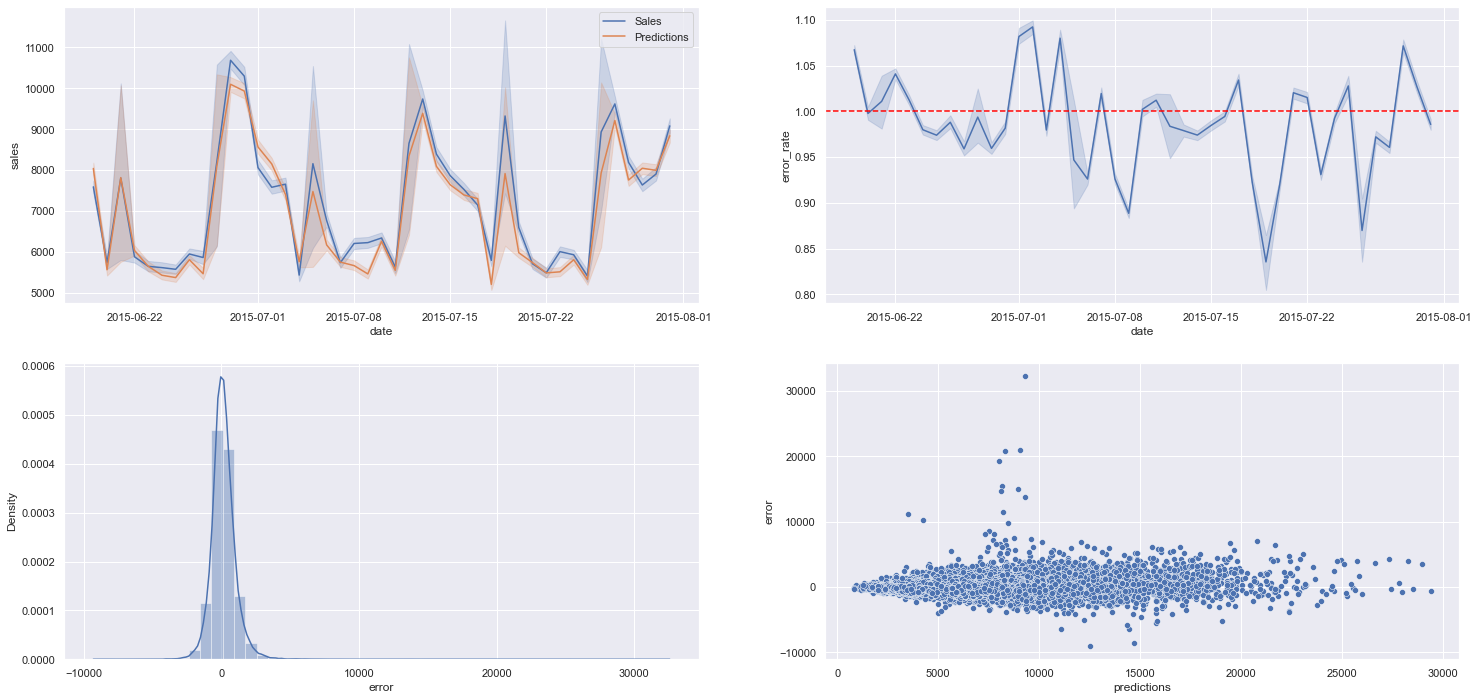

In [93]:
plt.subplot(2,2,1)

sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Sales');
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'Predictions');


plt.subplot(2,2,2)

sns.lineplot(x = 'date', y = 'error_rate', data = df9);
plt.axhline(1, linestyle = '--', color = 'red');


plt.subplot(2,2,3)

sns.distplot(df9['error']);



plt.subplot(2,2,4)

sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 CRIAÇÃO DA API

Embora tenham seus códigos desenvolvidos dentro do Jupyter Notebook, tanto o 'Rossmann Class' quanto a 'API Handler' foram colocados em arquivos .py e podem ser encontrados no repositório deste projeto.

In [111]:
# salvando o modelo treinado

pickle.dump(model_xgb_tuned, open('/Users/herna/repos/Data_Science_em_Producao/Model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [105]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    
    def __init__(self):
        self.competition_distance_scaler      = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler    = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler           = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                      = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding              = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/Parameter/store_type_encoding.pkl', 'rb'))
        
        
    def data_cleaning(self, df1):


        ## 1.1 Renomeando colunas

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename

        df1.columns = cols_new


        ## 1.3 Tipagem dos dados

        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5 Fill NA


        # competition_distance 
        # quando a observação não possui dados da variável competition_distance é porque o concorrente mais próximo está muito distante

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x) 


        # competition_open_since_month
        # mesmo não sabendo a data de abertura de alguns concorrentes, eles existem, e dessa forma, para preencher os NAs, utiliza-se a própria data da venda

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


        # competition_open_since_year
        # nesta variável, os dados faltantes foram preenchidos utilizando a mesma metodologia da variável anterior

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        # promo2_since_week
        # mesma metodologia das variáveis anteriores

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        # promo2_since_year 
        # mesma metodologia das variáveis anteriores

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



        # promo_interval
        # verificar se no dia da venda a loja estava em promoção

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Modificação da tipagem dos dados

        df1.dtypes

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        
        return df1

    
    def featuring_engineering(self, df2):
    

        # year

        df2['year'] = df2['date'].dt.year


        # month

        df2['month'] = df2['date'].dt.month


        # day

        df2['day'] = df2['date'].dt.day


        # week of year

        df2['week_of_year'] = df2['date'].dt.weekofyear


        # year week

        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since

        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


        # promo since

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


        # assortment

        df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x =='a' else 'extra' if x=='b' else 'extended')


        # stateholiday

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        # 3.0 Filtragem de Variáveis


        ## 3.1 Filtragem das linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2 Filtragem das colunas

        cols_drop = ['open', 'promo_interval','month_map']

        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
    
        df5['competition_time_month'] = np.int64(df5['competition_time_month'])
        df5['promo_time_week'] = np.int64(df5['promo_time_week'])

        ## 5.1 Rescaling

        # competition distance

        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)


        # competition time month

        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        
        # promo time week

        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        
        # year

        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.2 Transformação

        ### 5.2.1 Encoding

        # state_holiday - one hot encoding

        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - label encoding


        df5['store_type'] = self.store_type_encoding.fit_transform(df5['store_type'])


        # assortment - ordinal encoding

        assortment_dict = {'basic':1,
                           'extended':2,
                           'extra':3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.2.3 Variáveis de Natureza Cíclica

        # month

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # day of week

        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )    
        
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
        'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos','day_of_week_sin','day_of_week_cos']
        
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # predição
        pred = model.predict( test_data )
        
        # join dados e a predição
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [112]:
import pandas as pd
import pickle
from flask              import Flask, request, Response
from Rossmannclass.Rossmann  import Rossmann


# loading model

model = pickle.load(open('C:/Users/herna/repos/Data_Science_em_Producao/Model/model_rossmann.pkl', 'rb'))

# inicializar API

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # se houver dados
        
        if isinstance(test_json, dict):  # um exemplo      
            test_raw = pd.DataFrame(test_json, index=[0])        
        else:  # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
            
        # instanciando a rossmann class
        
        pipeline = Rossmann()
        
        # limpeza dos dados
        
        df1 = pipeline.data_cleaning(test_raw)
        
        # featuring engineering
        
        df2 = pipeline.featuring_engineering(df1)
        
        # data preparation
        
        df3 = pipeline.data_preparation(df2)
        
        # predict
        
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else: 
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## 10.3 API Tester

In [113]:
import json
import requests

In [114]:
df10 = pd.read_csv('Data/test.csv')

In [115]:
# dataset de test + store

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# escolhendo lojas para a predição

df_test = df_test[df_test['Store'].isin([24, 12, 10])]

# remover dias fechados

df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [116]:
# converter dataframe em json

data = json.dumps(df_test.to_dict(orient='records'))

In [117]:
# API Call

url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post(url, data=data, headers=header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [118]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [119]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks!'.format(d2.loc[i,'store'], d2.loc[i, 'prediction']))

Store Number 10 will sell $207,077.62 in the next 6 weeks!
Store Number 12 will sell $263,203.02 in the next 6 weeks!
Store Number 24 will sell $331,460.89 in the next 6 weeks!


# FIM!